In [11]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

In [2]:
from matplotlib import pyplot as plt

In [3]:
def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, padding='same'):
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding)(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x

In [4]:
isee_machine = pd.read_csv('./data/isee_machine_NG.csv',encoding= 'cp949')
isee_machine2 = isee_machine[isee_machine['Operation_label']==1]

In [5]:
isee_machine.shape, isee_machine2.shape

((236696, 28), (233994, 28))

In [7]:
feature = isee_machine2[[ 'CycleTime', 'VpPosition', 'VpTime',
       'VpPressure', 'MaxInjectionPressure', 'InjectionEndPosition',
       'PlasticizingTime', 'PlasticsEndPosotion', 'ClampingTime',
       'MouldOpeningTime', 'HotOilContoller', 'TankTemp', 'NozzleTemp',
       'Zone1', 'Zone2', 'Zone3', 'Zone4']]
y_label = isee_machine2[['NG5','CycleNum']]

len(feature), len(y_label)

(233994, 233994)

In [8]:
###  scaling
scaled_X = preprocessing.StandardScaler().fit_transform(feature)

C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [9]:
X_train = np.reshape(scaled_X, (scaled_X.shape[0], scaled_X.shape[1], 1, 1))

In [12]:
#######################################
# CNN1D AutoEncoder 구축
#######################################

input_data = Input(shape=X_train.shape[1:]) # 1ch=black&white

#@@ C-AE 구현http://localhost:8888/notebooks/Desktop/%EA%B8%88%ED%98%95/python/AutoEncoder/CNN1DAE.ipynb#
filter1 = 8
filter2 = 4

x = Conv2D(filter1, kernel_size= (17,1), activation='relu')(input_data)
#x = MaxPooling2D((17, 1), border_mode='same')(x)
x = Conv2D(filter2, kernel_size= (1,1), activation='relu')(x)
encoded = Conv2D(1, kernel_size= (1,1), activation='sigmoid')(x)

x = Conv2DTranspose(filter2, kernel_size= (1,1), activation='relu')(encoded)
x = Conv2DTranspose(filter1, kernel_size= (1,1), activation='relu')(x)
#x = UpSampling2D((17, 1))(x)
decoded = Conv2DTranspose(1, kernel_size=(17,1), activation='sigmoid')(x)

adam = optimizers.Adam(lr=0.01)
autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer=adam, loss='mse')

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 17, 1, 1)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 8)           144       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 4)           36        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 1)           5         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 1, 1, 4)           8         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 1, 1, 8)           40        
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 17, 1, 1)          137       
Total para

In [13]:
early_stopping = EarlyStopping(patience=3, mode='min')
autoencoder.fit(X_train, X_train, epochs= 100, batch_size=1024, shuffle=True, verbose=1, validation_split=0.05, callbacks=[early_stopping]) 

Train on 222294 samples, validate on 11700 samples
Epoch 1/100
222294/222294 [==============================] - 3s 15us/step - loss: 0.9976 - val_loss: 0.4819
Epoch 2/100
222294/222294 [==============================] - 3s 12us/step - loss: 0.9299 - val_loss: 0.4799
Epoch 3/100
222294/222294 [==============================] - 3s 11us/step - loss: 0.8909 - val_loss: 0.4780
Epoch 4/100
222294/222294 [==============================] - 3s 13us/step - loss: 0.8570 - val_loss: 0.4783
Epoch 5/100
222294/222294 [==============================] - 2s 11us/step - loss: 0.8391 - val_loss: 0.4778
Epoch 6/100
222294/222294 [==============================] - 2s 11us/step - loss: 0.8334 - val_loss: 0.4774
Epoch 7/100
222294/222294 [==============================] - 2s 11us/step - loss: 0.8307 - val_loss: 0.4776
Epoch 8/100
222294/222294 [==============================] - 3s 12us/step - loss: 0.8287 - val_loss: 0.4773
Epoch 9/100
222294/222294 [==============================] - 2s 11us/step - loss: 0.8

In [14]:
encoder = Model(input_data, encoded)
#encoder.compile(optimizer='adadelta', loss='mse')
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 17, 1, 1)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 8)           144       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 4)           36        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 1)           5         
Total params: 185
Trainable params: 185
Non-trainable params: 0
_________________________________________________________________


In [15]:
enco_train_pred = encoder.predict(X_train)
enco_train_re = np.reshape(enco_train_pred,(isee_machine2.shape[0],))
enco_train_re.shape

(233994,)

In [51]:
isee_machine2['encoding']=enco_train_re

C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


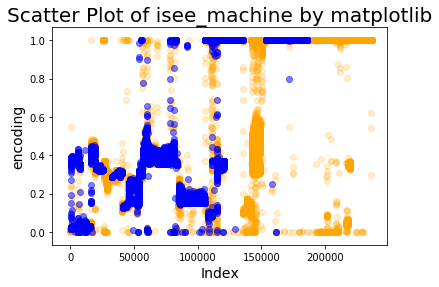

In [55]:

plt.scatter(isee_machine2[isee_machine2['NG5']==0].index, isee_machine2[isee_machine2['NG5']==0]['encoding'], c='orange', label=name, alpha=0.2)
plt.scatter(isee_machine2[isee_machine2['NG5']==1].index, isee_machine2[isee_machine2['NG5']==1]['encoding'], c='blue', label=name, alpha=0.5)

ax.legend(fontsize=12, loc='upper left') # legend position

plt.title('Scatter Plot of isee_machine by matplotlib', fontsize=20)

plt.xlabel('Index', fontsize=14)

plt.ylabel('encoding', fontsize=14)

plt.show()


In [19]:
import pickle
with open('enco_train.pickle', 'wb') as f:
     pickle.dump(enco_train_re, f)

In [20]:
enlis = enco_train_re.tolist()
enlis.insert(0,0)
enlis.pop()

1.0

In [21]:
len(enlis)

233994

In [22]:
isee2 = pd.concat([isee_machine,pd.DataFrame(enlis, columns=['encoding'])], axis=1)
isee2

,ModuleCount,creationTime,CycleTime,VpPosition,VpTime,VpPressure,MaxInjectionPressure,InjectionEndPosition,PlasticizingTime,PlasticsEndPosotion,...,creationDate,creationHour,YM,creationTime_diff,CycleNum,Operation_label,Qua_Match_YN,NG,NG5,encoding
0,270163,2018-09-01 19:07:00,60.45,25.0,4.87,43,83,9.7,20.43,97.1,...,2018-09-01,19,2018-09,0.0,1,0,1,0,0,0.000000
1,270164,2018-09-01 19:07:00,42.11,25.0,5.06,48,61,18.4,16.93,97.3,...,2018-09-01,19,2018-09,0.0,1,0,1,0,0,0.008458
2,270165,2018-09-01 19:08:00,42.10,25.0,4.97,50,65,15.9,15.68,97.2,...,2018-09-01,19,2018-09,60.0,1,0,1,0,0,0.010396
3,270166,2018-09-01 19:09:00,42.09,25.0,4.96,50,66,14.6,15.28,97.1,...,2018-09-01,19,2018-09,60.0,1,0,1,0,0,0.010064
4,270167,2018-09-01 19:10:00,42.09,25.0,4.96,55,67,24.0,15.28,97.2,...,2018-09-01,19,2018-09,60.0,1,0,1,0,0,0.010698
5,270168,2018-09-01 19:10:00,42.09,25.0,4.81,55,70,12.0,14.92,96.8,...,2018-09-01,19,2018-09,0.0,1,0,1,0,0,0.010963
6,270169,2018-09-01 19:11:00,42.09,25.0,4.90,57,75,15.7,13.97,97.1,...,2018-09-01,19,2018-09,60.0,1,0,1,0,0,0.011374
7,270170,2018-09-01 19:12:00,42.09,25.0,4.90,57,77,22.3,13.97,97.1,...,2018-09-01,19,2018-09,60.0,1,0,1,0,0,0.011266
8,270171,2018-09-01 19:12:00,42.12,25.0,4.99,60,78,16.7,13.09,97.2,...,2018-09-01,19,2018-09,0.0,1,0,1,0,0,0.013268
9,270172,2018-09-01 19:13:00,42.12,25.0,4.99,60,80,22.9,13.09,97.2,...,2018-09-01,19,2018-09,60.0,1,1,1,0,0,0.012027


In [23]:
isee2[isee2['CycleNum']==3].index

Int64Index([250, 251, 252, 253, 254, 255, 256, 257, 258, 259,
            ...
            492, 493, 494, 495, 496, 497, 498, 499, 500, 501],
           dtype='int64', length=252)

In [24]:
new_isee = pd.DataFrame()
for i in np.unique(isee2['CycleNum']):
    df = isee2[isee2['CycleNum']==i]
    delnum = df.index[0]
    df = df.drop(delnum)
    new_isee = pd.concat([new_isee,df],axis=0)

In [25]:
new_isee.shape

(236536, 29)

In [26]:
new_isee.to_csv('./data/isee_machine_NG_enc.csv',encoding= 'cp949',index = False)